<a href="https://colab.research.google.com/github/palashbaranwal/MNIST_BatchNorm_Regularization/blob/master/Assignment_6_L1_and_L2_Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

print(1+10)


11


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)
print(9+46)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!
55


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


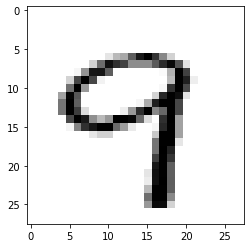

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

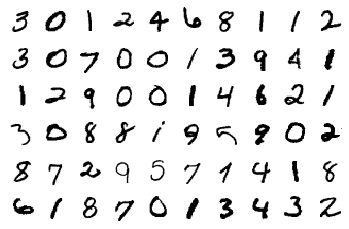

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        # self.convblock4 = nn.Sequential(
        #     nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            
            
        #     nn.ReLU()
        # ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        # self.convblock7 = nn.Sequential(
        #     nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        #     nn.BatchNorm2d(10),
        #     nn.ReLU()
        # ) # output_size = 7
         
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 5

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 3

        # self.convblock9 = nn.Sequential(
        #     nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        # ) # output_size = 5

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=3)
        ) # output_size = 1



        # self.convblock8 = nn.Sequential(
        #     nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
        #     # nn.BatchNorm2d(10), NEVER
        #     # nn.ReLU() NEVER!
        # ) # output_size = 1

        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        #x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.dropout(x)
        #x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.gap(x)
        #x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))
print("Check {0}",str("1+2"))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]             900
       BatchNorm2d-5           [-1, 10, 24, 24]              20
              ReLU-6           [-1, 10, 24, 24]               0
            Conv2d-7           [-1, 10, 22, 22]             900
       BatchNorm2d-8           [-1, 10, 22, 22]              20
              ReLU-9           [-1, 10, 22, 22]               0
        MaxPool2d-10           [-1, 10, 11, 11]               0
           Conv2d-11             [-1, 10, 9, 9]             900
      BatchNorm2d-12             [-1, 10, 9, 9]              20
             ReLU-13             [-1, 10, 9, 9]               0
           Conv2d-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0

  # https://discuss.pytorch.org/t/l1-regularization-for-a-single-matrix/28088/2
  criterion = nn.CrossEntropyLoss().to(device)
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    reg_loss = 0 
    #l1_crit = nn.L1Loss(size_average=False)
    for param in model.parameters():
      #if param.dim()>1:
      reg_loss +=  torch.sum(abs(param))
        #reg_loss +=  param.norm(1)
        #reg_loss+=l1_crit(param)
    classify_loss = criterion(y_pred,target)

    #factor = 0.0005
    factor = 0.00003
    loss = classify_loss + factor * reg_loss
    #loss += factor * reg_loss
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [14]:
from torch.optim.lr_scheduler import StepLR
import datetime

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    print(datetime.datetime.now())
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0
2020-03-08 19:18:00.543344


Loss=0.11859771609306335 Batch_id=468 Accuracy=93.61: 100%|██████████| 469/469 [00:17<00:00, 27.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0974, Accuracy: 9848/10000 (98.48%)

EPOCH: 1
2020-03-08 19:18:19.927495


Loss=0.08714194595813751 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:17<00:00, 27.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0593, Accuracy: 9863/10000 (98.63%)

EPOCH: 2
2020-03-08 19:18:39.405566


Loss=0.03956494480371475 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:17<00:00, 34.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0431, Accuracy: 9912/10000 (99.12%)

EPOCH: 3
2020-03-08 19:18:58.852543


Loss=0.11158724129199982 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:17<00:00, 27.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0395, Accuracy: 9917/10000 (99.17%)

EPOCH: 4
2020-03-08 19:19:18.378456


Loss=0.05865249037742615 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:17<00:00, 27.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0341, Accuracy: 9925/10000 (99.25%)

EPOCH: 5
2020-03-08 19:19:37.913096


Loss=0.05342807620763779 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:17<00:00, 27.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0436, Accuracy: 9885/10000 (98.85%)

EPOCH: 6
2020-03-08 19:19:57.323871


Loss=0.05580759048461914 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:17<00:00, 27.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Accuracy: 9935/10000 (99.35%)

EPOCH: 7
2020-03-08 19:20:16.683676


Loss=0.027502194046974182 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:17<00:00, 26.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0344, Accuracy: 9930/10000 (99.30%)

EPOCH: 8
2020-03-08 19:20:36.309282


Loss=0.03389200195670128 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:17<00:00, 27.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0305, Accuracy: 9929/10000 (99.29%)

EPOCH: 9
2020-03-08 19:20:55.826605


Loss=0.13999801874160767 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:17<00:00, 32.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9928/10000 (99.28%)

EPOCH: 10
2020-03-08 19:21:15.197589


Loss=0.04178154096007347 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:17<00:00, 27.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 9938/10000 (99.38%)

EPOCH: 11
2020-03-08 19:21:34.712446


Loss=0.07393424212932587 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:17<00:00, 27.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9942/10000 (99.42%)

EPOCH: 12
2020-03-08 19:21:54.221868


Loss=0.07210353016853333 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:17<00:00, 27.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9937/10000 (99.37%)

EPOCH: 13
2020-03-08 19:22:13.667978


Loss=0.03892926126718521 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:17<00:00, 27.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0309, Accuracy: 9927/10000 (99.27%)

EPOCH: 14
2020-03-08 19:22:33.145192


Loss=0.06439532339572906 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:17<00:00, 27.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9926/10000 (99.26%)

EPOCH: 15
2020-03-08 19:22:52.613285


Loss=0.04950171709060669 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:17<00:00, 26.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Accuracy: 9931/10000 (99.31%)

EPOCH: 16
2020-03-08 19:23:12.260092


Loss=0.04079899936914444 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:18<00:00, 26.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9940/10000 (99.40%)

EPOCH: 17
2020-03-08 19:23:32.457760


Loss=0.04604749009013176 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:17<00:00, 26.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0292, Accuracy: 9925/10000 (99.25%)

EPOCH: 18
2020-03-08 19:23:52.135946


Loss=0.03401492163538933 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:17<00:00, 27.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0300, Accuracy: 9931/10000 (99.31%)

EPOCH: 19
2020-03-08 19:24:11.636160


Loss=0.051338307559490204 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:17<00:00, 27.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Accuracy: 9935/10000 (99.35%)

EPOCH: 20
2020-03-08 19:24:31.181719


Loss=0.02576294168829918 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:17<00:00, 26.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0316, Accuracy: 9916/10000 (99.16%)

EPOCH: 21
2020-03-08 19:24:50.790876


Loss=0.023975837975740433 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:17<00:00, 27.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0272, Accuracy: 9935/10000 (99.35%)

EPOCH: 22
2020-03-08 19:25:10.316451


Loss=0.029208801686763763 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:17<00:00, 26.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Accuracy: 9934/10000 (99.34%)

EPOCH: 23
2020-03-08 19:25:29.932090


Loss=0.05824772268533707 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:17<00:00, 26.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9931/10000 (99.31%)

EPOCH: 24
2020-03-08 19:25:49.616828


Loss=0.05471557751297951 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:17<00:00, 34.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Accuracy: 9928/10000 (99.28%)

EPOCH: 25
2020-03-08 19:26:09.180263


Loss=0.09357018023729324 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:17<00:00, 27.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9934/10000 (99.34%)

EPOCH: 26
2020-03-08 19:26:28.674196


Loss=0.03234724700450897 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:17<00:00, 26.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9944/10000 (99.44%)

EPOCH: 27
2020-03-08 19:26:48.399405


Loss=0.0424620546400547 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:17<00:00, 26.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9942/10000 (99.42%)

EPOCH: 28
2020-03-08 19:27:08.007031


Loss=0.02888524904847145 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:17<00:00, 33.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9941/10000 (99.41%)

EPOCH: 29
2020-03-08 19:27:27.607779


Loss=0.056864019483327866 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:17<00:00, 32.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9935/10000 (99.35%)

EPOCH: 30
2020-03-08 19:27:47.239482


Loss=0.06315357238054276 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:17<00:00, 27.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9943/10000 (99.43%)

EPOCH: 31
2020-03-08 19:28:06.681386


Loss=0.05502542108297348 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:17<00:00, 26.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9944/10000 (99.44%)

EPOCH: 32
2020-03-08 19:28:26.378946


Loss=0.04140220582485199 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:17<00:00, 33.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9918/10000 (99.18%)

EPOCH: 33
2020-03-08 19:28:45.896644


Loss=0.05705859884619713 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:17<00:00, 27.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9934/10000 (99.34%)

EPOCH: 34
2020-03-08 19:29:05.399455


Loss=0.03151765465736389 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:17<00:00, 27.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9937/10000 (99.37%)

EPOCH: 35
2020-03-08 19:29:24.985353


Loss=0.039762742817401886 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:17<00:00, 26.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9927/10000 (99.27%)

EPOCH: 36
2020-03-08 19:29:44.603020


Loss=0.04752013832330704 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:17<00:00, 27.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0347, Accuracy: 9897/10000 (98.97%)

EPOCH: 37
2020-03-08 19:30:04.167065


Loss=0.028930263593792915 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:17<00:00, 27.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0272, Accuracy: 9925/10000 (99.25%)

EPOCH: 38
2020-03-08 19:30:23.637613


Loss=0.03320082277059555 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:17<00:00, 27.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9939/10000 (99.39%)

EPOCH: 39
2020-03-08 19:30:43.256624


Loss=0.06826769560575485 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:17<00:00, 27.12it/s]



Test set: Average loss: 0.0254, Accuracy: 9934/10000 (99.34%)



Text(0.5, 1.0, 'Test Accuracy')

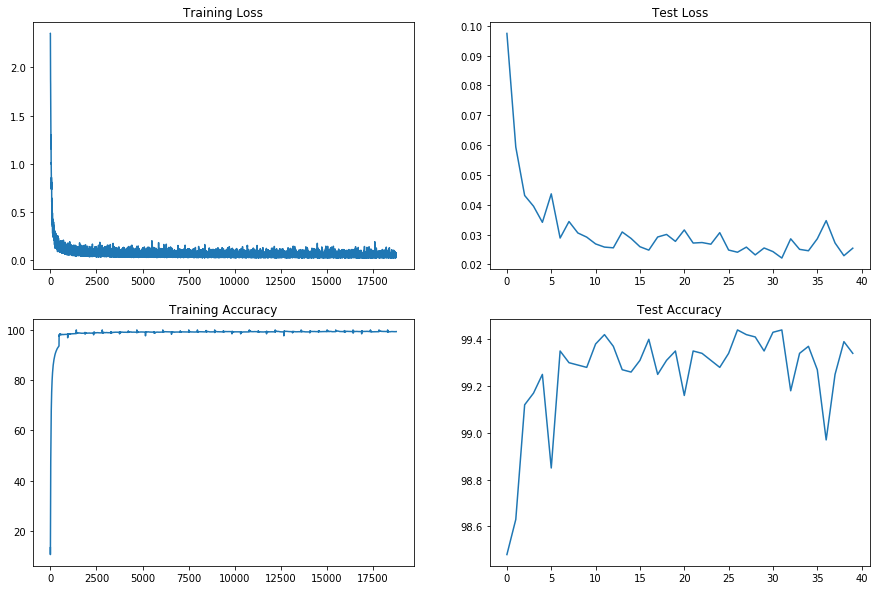

In [15]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")